# Population structure in R


<br>


## Overview

In the last module, `1_ipyrad.ipynb`, we started with an ipyrad tutorial to process RADseq data from the red diamond rattlesnake (Crotalus ruber). We assembled the data from raw reads into aligned sequences, generating files that contain SNPs (single nucleotide polymorphisms) or loci on a common coordinate system for each individual sample. This alignment enables us to make inferences based on variation across samples. In this module, we'll perform basic population genetic analyses to examine population structure, running all analyses in R.

We will continue with the snake data that we assembled in the previous module, but note that these population genetic methods can be used with any kind of genomic or sub-genomic sequence data, and can be applied in a variety of contexts including studying [pathogen evolution](https://onlinelibrary.wiley.com/doi/10.1111/mec.16395) and [human population genetics and admixture](https://link.springer.com/article/10.1186/s13323-015-0024-0).



## Learning objectives

1. Calculate basic population summary statistics
2. Identify and plot population clusters
3. Test for and visualize isolation by distance



## Prerequisites

All necessary software is included in the container that we will use on Google Cloud: `us-east4-docker.pkg.dev/nih-cl-shared-resources/nigms-sandbox/nigms-vertex-r-wy`

If you are not using the container, you will need to install the following software:

- **R**: This notebook runs in an R kernel
- **R packages**: The following R packages are required:
    - vcfR
    - adegenet
    - LEA
    - mapdata
    - ggplot2
    - scatterpie
    - mapproj
    - fossil
    - MASS



<br>
<br>
<br>
<br>
<br>

# Get started

<br>


## Setup

### Data download

If you successfully ran through the previous tutorial (`1_ipyrad.ipynb`) in the same Google Cloud instance that you are running this notebook from, then you should have all necessary files to start this notebook.


If you did not run through the previous tutorial or are running this tutorial from a fresh instance, you can download the ipyrad output we provide in the "radseq_cloud" Google bucket. Only uncomment and run these next lines if you want to download the ipyrad assembly.

In [1]:
# system("gsutil -m cp -r gs://radseq_cloud/ .", intern = TRUE)
# system("mkdir -p ./ipyrad_out/ruber_reduced_denovo_outfiles/")
# system("cp ./radseq_cloud/ruber-ipyrad-out/* ipyrad_out/ruber_reduced_denovo_outfiles/", intern = TRUE)

### Package installs

Because we are using a container that already has all of the necessary R packages installed, we won't install any packages. If you want to run the following code in a different context, you'll need to uncomment and run the following lines. It may take several minutes to install all of these packages.

In [2]:
# install.packages(c("adegenet", "plotrix", "mapdata", "BiocManager", "vcfR", "fossil", "scatterpie", "mapproj", "MASS"))
# BiocManager::install("LEA")

From our container, or once you have installed packages if not using the container, we can load up the packages:

In [3]:
# Load necessary packages
library(vcfR)
library(adegenet)
library(LEA)
library(mapdata)
library(ggplot2)
library(scatterpie)
library(mapproj)
library(fossil)
library(MASS)
library(IRdisplay)


   *****       ***   vcfR   ***       *****
   This is vcfR 1.15.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****


Loading required package: ade4


   /// adegenet 2.1.10 is loaded ////////////

   > overview: '?adegenet'
   > tutorials/doc/questions: 'adegenetWeb()' 
   > bug reports/feature requests: adegenetIssues()



Loading required package: maps

scatterpie v0.2.4 Learn more at https://yulab-smu.top/



Loading required package: sp


Attaching package: ‘sp’


The following object is masked from ‘package:scatterpie’:

    recenter


Loading required package: shapefiles

Loading required package: foreign


Attaching package: ‘shapefiles’


The following objects are masked from ‘package:foreign’:

    read.dbf, write.dbf




### Specify some paths & objects

Then we will specify a number of file paths and read in a few files so that we don’t have to repeatedly hardcode file paths farther down in the notebook. This makes it easier to reuse the script on different datasets or the same data with different filtering schemes without having to search through the script to find every time an absolute file path is specified.

In [4]:
## Set up an object containing the path to the data
data_dir <- "/home/jupyter/Population-Genomics-and-Phylogenetics-with-RADseq/ipyrad_out/ruber_reduced_denovo_outfiles"

## make a directory to put the output plots into
##    this can be wherever you like, I'm putting it into the directory that contains
##    my scripts and ipyrad output directories
out_dir <- "/home/jupyter/Population-Genomics-and-Phylogenetics-with-RADseq/pop_struct_out"
if(!dir.exists(out_dir)){ # check if the directory  exists and return TRUE if it does not
  dir.create(out_dir)   # create the directory if it does not exist
}

# Set up an object that contains the base file name of files in the output directory. 
#    Data files are all this basename with varying extensions
#  we won't call this 'basename' because that is a function in R
#  setting up the files this way allows us to easily run this script on another assembly 
#    without needing to edit file names everywhere they occur
basefile <- "ruber_reduced_denovo"

# Read in the geographic coordinates for plotting later
coords <- read.csv("/home/jupyter/Population-Genomics-and-Phylogenetics-with-RADseq/population-genomics/ruber_data/Localities.csv", header=TRUE, row.names=NULL)



####################################################################################
## Set up paths to input files using the base file name specified above
####################################################################################
path_ugeno <- paste0(data_dir,"/", basefile,".ugeno")
path_ustr <- paste0(data_dir,"/", basefile,".ustr")
path_vcf <- paste0(data_dir,"/", basefile,".vcf")

### Set up some colors for plotting farther down
colors_2 <- c("red", "blue") # colors for plotting 2 populations


# Set the working directory to the output directory
setwd(out_dir) # set directory as the output directory

## Basic stats

Let's start by reading in the data and calculating some very basic population genetic summary statistics.

Read in the data from the vcf file, this should spit out some basic information about how many variants are in the dataset:

In [5]:
gendata_all <- read.vcfR(path_vcf) # read in all of the genetic data from the vcf file
gendata <- vcfR2genind(gendata_all) # convert to genind format

Scanning file to determine attributes.
File attributes:
  meta lines: 10
  header_line: 11
  variant count: 2885
  column count: 42
Meta line 10 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 2885
  Character matrix gt cols: 42
  skip: 0
  nrows: 2885
  row_num: 0
Processed variant: 2885
All variants processed


Calculate observed and expected heterozygosity:


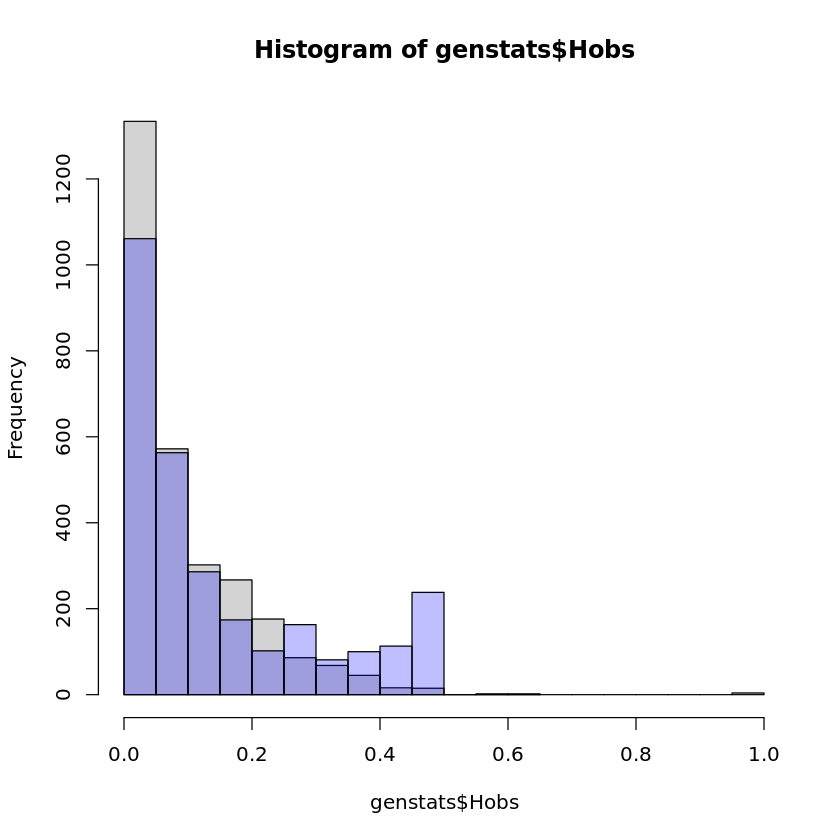

In [6]:
# Use adegenet's summary function on the genind object
genstats <- summary(gendata)

# and make overlapping histograms
hist(genstats$Hobs, breaks = 15)
hist(genstats$Hexp, add = TRUE, col = scales::alpha('blue',.25))

You should see something like this:



<details>
  <summary>Click to show expected plot</summary>
  <img src="images/hobs_plot.png" width=35% />
</details>

<br>

The gray bars show our observed heterozygosity, which looks to be lower than expected heterozygosity (blue bars). Let's check the means of each to confirm:

In [7]:
# and look at the mean of each
mean(genstats$Hobs)
mean(genstats$Hexp)

[1] 0.09911455

[1] 0.1528145

You should see that we have low observed heterozygosity compared to expected. One likely reason for this is the presence of population structure in the data. We'll test for this shortly.

## Principal components analysis


Principal component analysis, or PCA, is a common dimensionality reduction method to see how data cluster without assigning groups or number of groups a priori. We can apply this method to genetic as well as other types of data. We'll generally follow [documentation from the adegenet package to run PCA on our data](https://adegenet.r-forge.r-project.org/files/PRstats/practical-MVAintro.1.0.pdf):


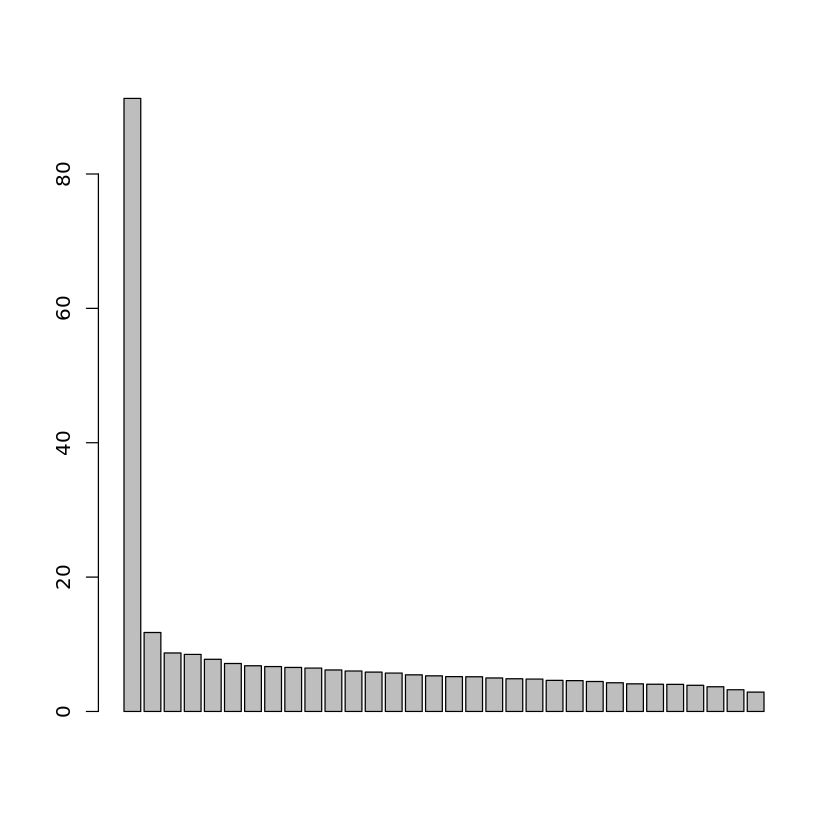

In [8]:
# calculate allele frequencies and replace NAs by imputing with mean values
genfreq <- tab(gendata, freq=TRUE, NA.method="mean")

# Run PCA
pca_res <- dudi.pca(genfreq, center = TRUE, scale = FALSE, scannf = FALSE, nf = 0)

# plot eigenvalues
barplot(pca_res$eig)

The eigenvalues (height of the bars) for each of these components roughly corresponds to the amount of genetic variation explained by each principal component. General advice is to retain all components before they drop off sharply. 



<details>
  <summary>Click to show expected plot</summary>
  <img src="images/eigen.png" width=30% />
</details>


<br>

We need to retain at least 2 to make the plots we want, so let's re-run our PCA keeping 2 axes and then plot it out.

- Note that if you are running R somewhere other than a Jupyter notebook, like RStudio, you can run `pca_res <- dudi.pca(genfreq, center=TRUE, scale=FALSE)`  and it will show you a plot of the eigenvalues and ask you how many axes you want to retain interactively.

- Also note that in the above code block, we imputed missing data values with mean values. This can be a fine strategy if you don't have too much missing data, but if you have lots of missing data, you will want to think carefully about how you impute missing data or use a method that can accomodate missing data without imputation.

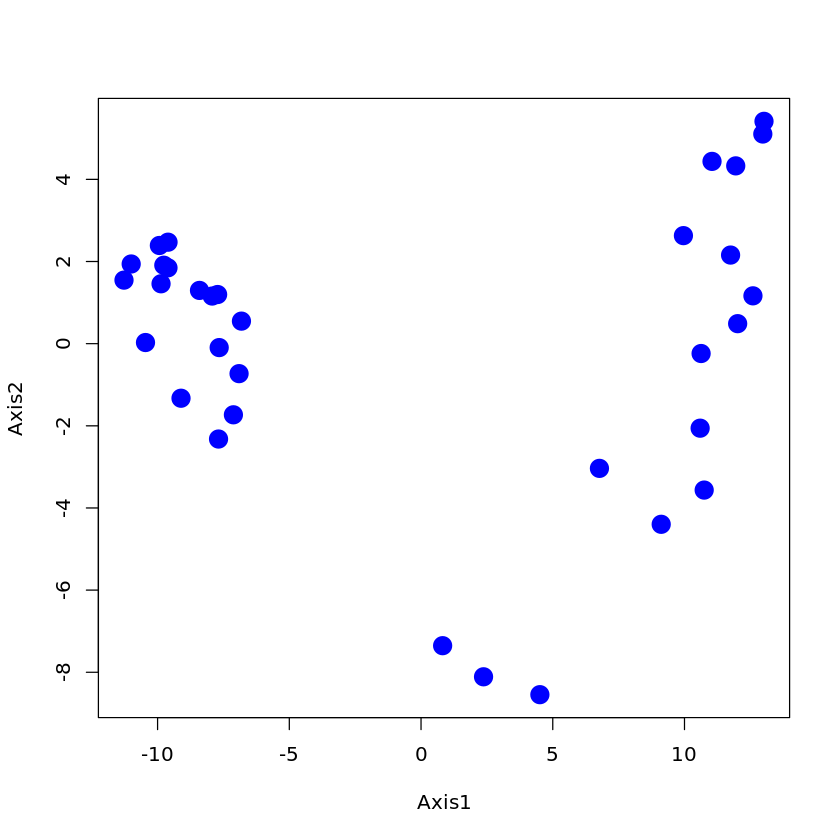

In [9]:
# Run PCA retaining only 2 axes
pca_res <- dudi.pca(df = genfreq, center = TRUE, scale = FALSE, scannf = FALSE, nf = 2)

# plot it out
plot(pca_res$li, pch = 19, cex = 2, col = "blue")

You should get something like this:


<details>
  <summary>Click to show expected plot</summary>
  <img src="images/PCA1.png" width=40% />
</details>

<br>

It looks like we probably have 2 distinct populations with some admixed individuals in between them. Next, we'll run a population clustering method to test this.


<br>
<br>
<br>

## Population structure using sNMF

Population assignment is a critical step in many population genetic and phylogeographic studies. Most downstream methods for estimating gene flow, divergence, population size, and other interesting population parameters require populations to be specified by you. If you have population structure in your data that you have not adequately accounted for, this can bias many types of analyses. E.g., if you try to estimate the history of population size changes in a group of samples that you assume are a single population when they actually come from multiple discrete populations, this will bias your results. Similarly, if you are running genome-wide association studies (GWAS) to identify genes that are associated with some phenotype, including unaccounted population structure can result in the identification of spurious associations.

There are multiple ways to assign individuals to discrete populations. In some cases, you may have a priori ideas about population boundaries based on geographic discontinuities, differences in morphology across a species range, previous genetic data, or other sources of information. However, most of the time you will want to infer the number of populations and population membership of individuals directly from your data. This is essentially a classification problem: we are seeking to classify our whole set of genetic samples into a number of populations, often while also seeking to determine how many populations are present.

One of the most commonly used programs for the inference of population structure is the aptly named program [Structure](https://web.stanford.edu/group/pritchardlab/structure.html). Structure is a model-based clustering method that seeks to split individuals into clusters such that linkage disequilibrium is minimized and Hardy-Weinberg equilibrium is maximized within each cluster. Structure is a Bayesian method that relies on Markov chain Monte Carlo (MCMC) sampling, and can thus become somewhat unwieldy with large datasets. Many fast alternatives have been developed since the advent of Structure, including [Admixture](https://dalexander.github.io/admixture/) which utilizes the same model from Structure, but in a faster maximum likelihood implementation. Other alternative approaches do not explicitly model Hardy-Weinberg equilibrium or linkage disequilibrium, including the sNMF approach implemented in the [LEA R package](http://membres-timc.imag.fr/Olivier.Francois/LEA/files/LEA_github.pdf) and DAPC as implemented in the [Adegenet R package](https://github.com/thibautjombart/adegenet). All of these methods often produce comparable results, which are often visualized as barplots of the estimated membership of each sample in one or more population clusters or as pie charts of the same information plotted onto a map as show in the figures below.

<img src="images/Admix_barplot.png" width=50% />
<img src="images/admix_map.png" width=50% />


<br>

If using DAPC to estimate population membership, it is important to note that in my experience, with large amounts of data, DAPC is very good at estimating which population a sample belongs to, but if a sample is admixed, it will be confidently placed into the population that it shares the most ancestry with. Barplots or pie charts of DAPC reflect the uncertainty in classification rather than amount of admixture, so care should be taken not to interpret DAPC plots the same way as plots from Strucure, Admixture, sNMF, etc.

**Here we will use sNMF**

I like to use sNMF rather than Structure because it's very fast and produces results highly similar to Structure. However, sNMF can have trouble with samples that have high amounts of missing data, with high missing data causing individuals to appear to be admixed. In such cases, the estimates of admixture that you get out of Structure or Admixture may be better than those from sNMF.

* The snmf function requires a `geno` file as input, and requires that it has the extension `.geno`. We want to use only unlinked SNPs here (i.e., 1 SNP per RAD locus, assumed to be unlinked), and the `geno` file of unlinked snps from ipyrad has the extension `ugeno`, so we'll copy the file and give it a new extension:

In [10]:
# Use a regular expression substitution to generate the new file name
path_geno<-gsub(".ugeno$", ".u.geno", path_ugeno)

file.copy(path_ugeno, path_geno) # do the copying with the new name

[1] TRUE

Now we’re ready to run sNMF. We’ll run this using 1 to 10 possible ancestral populations and evaluate the fit of these different numbers of populations (referred to as k values) to the data using the cross entropy criterion:

In [11]:
sink(tempfile()) # set the screen output to write to a temp file so that the notebook doesn't get too gummed up - delete to see all screen messages generated by sNMF

obj.at <- snmf(input.file = path_geno,  # input file is the .geno format file
               K = 1:10, # we will test for k=1 through 10
               ploidy = 2, 
               entropy = T, # use the cross entropy criterion for assessing the best k 
               repetitions = 10, # Run 10 independent replicate analyses
               CPU = 8, 
               project = "new", tolerance = 0.00001, iterations = 500)
sink()

Let’s make a plot of the cross-entropy plot

pdf 
  2

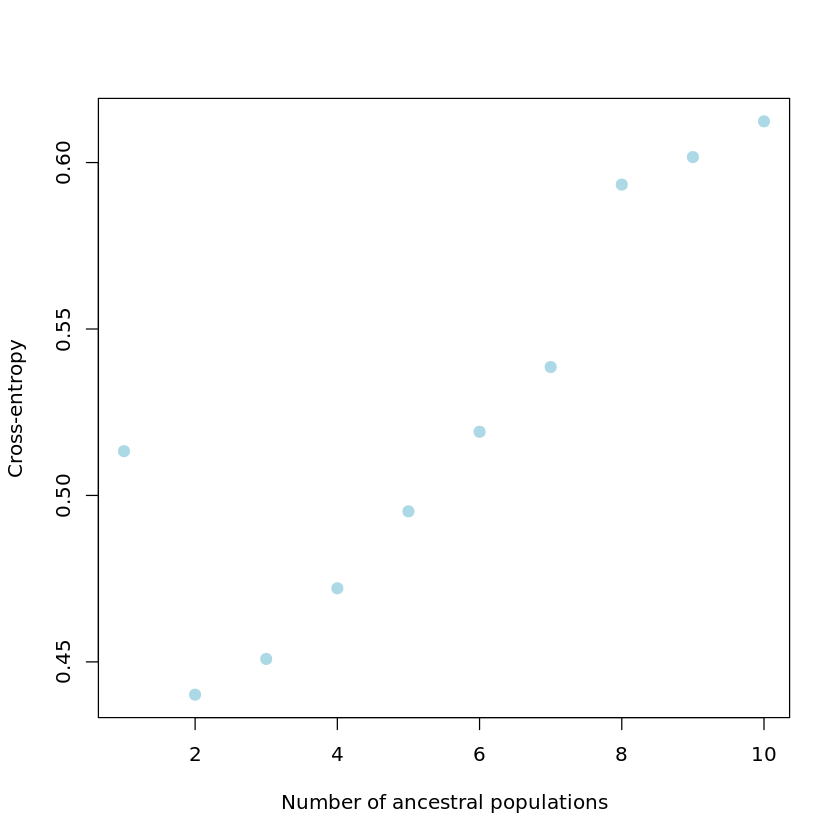

In [12]:
plot(obj.at, col = "lightblue", cex = 1.2, pch = 19)

# We could alternately plot this to pdf, which you can then use for publication:
pdf("snmf_cross_ent.pdf", width = 8, height=5)
plot(obj.at, col = "lightblue", cex = 1.2, pch = 19)
dev.off()

You should see that the best fit model is one with 2 populations, as shown by the lowest cross-entropy score:


<details>
  <summary>Click to show expected plot</summary>
  <img src="images/cross_entropy.png" width=37% />
</details>

<br>

We can also look at a numeric summary of this result:

In [13]:
outstats <- summary(obj.at)
outstats

,K = 1,K = 2,K = 3,K = 4,K = 5,K = 6,K = 7,K = 8,K = 9,K = 10
with cross-entropy,10,10,10,10,10,10,10,10,10,10
without cross-entropy,0,0,0,0,0,0,0,0,0,0
total,10,10,10,10,10,10,10,10,10,10
,K = 1,K = 2,K = 3,K = 4,K = 5,K = 6,K = 7,K = 8,K = 9,K = 10
min,0.5133095,0.4401599,0.4508922,0.4721122,0.4952224,0.5191274,0.5385884,0.5933740,0.6016485,0.6123832
mean,0.5314200,0.4616635,0.4759440,0.4979336,0.5297463,0.5577810,0.5844299,0.6251666,0.6500474,0.6662390
max,0.5583565,0.4879792,0.5128872,0.5483397,0.5719529,0.5948656,0.6122193,0.6641675,0.6944800,0.7243225


We can also confirm cross entropy values for K are consistent across runs and get the single best run for K=2.


In [14]:
ce <- cross.entropy(obj.at, K = 2) 
ce # pretty similar
best.run <- which.min(ce) # find the run with the lowest cross validation error


,K = 2
run 1,0.4534786
run 2,0.4591511
run 3,0.4678253
run 4,0.4879792
run 5,0.4636338
run 6,0.4472235
run 7,0.4401599
run 8,0.4732333
run 9,0.4698506
run 10,0.4540995


Then we can get the snmf Q matrix from the best run at the best k, which is a matrix of the proportion of ancestry that each sample derives from each population.

In [15]:
qmatrix <- Q(obj.at, K = 2, run = best.run)
admix <- as.data.frame(qmatrix)

This will let us plot out these proportions to a map, which we'll do next with a little additional setup.

## Plot population clusters to a map


Start by sorting out the coordinates of each individual into the same order as the individuals in the genetic data and make sure that there is geographic data for each individual in the genetic data



In [16]:
# Get individual names for the genetic data from the vcf file, read in as gendata above - individuals will be in the same order in all genetic data files output by ipyrad

ind_names <- rownames(gendata@tab)

ind_names[which(!ind_names %in% coords[,"Field.No."])] # check if there are any individuals not in the coordinates, there shouldn't be here, but if you're using your own data, this can help you catch any mislabeling/typos that frequently occur
# match up the coordinates to the order of the individuals from snmf
match_coords<-match(ind_names, coords[,"Field.No."])
snmf_coords<-coords[match_coords,]

# get the coordinate and admix data into a single dataframe to plot out these proportions on a map
for_pies <- cbind(snmf_coords, admix)

character(0)

Get out the mapping data for USA states and for Mexico and then combine them together


In [17]:
states <- map_data("state") # US states data
mex <- map_data("worldHires", "Mexico") # Mexico data
mex$group <- mex$group + max(states$group) # have to do this to get rid of weird lines that show up otherwise because of groups in Mexico already being group numbers in states - there is probably a bette way to do this
to_map <- rbind(states, mex) # combine these together


Use ggplot to plot scatterpies on a map using the objects we just set up:

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


pdf 
  2

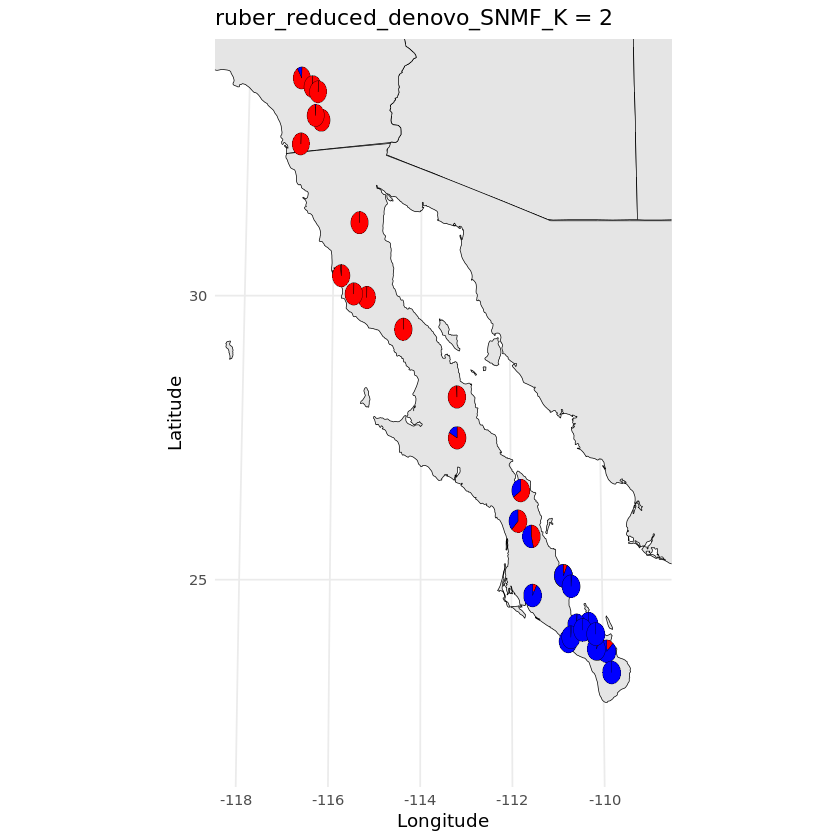

In [18]:
snmf_plot <- ggplot(to_map, aes(long, lat, group = group)) + # map out the US & Mexico
  geom_polygon(data = to_map, fill = "grey90", color = "black", size = 0.2) + # make them polygons
  geom_scatterpie(data = for_pies, aes(x=Longitude, y=Latitude, group = Field.No., r = 0.2), cols = grep("^V", colnames(for_pies), value = TRUE), size = 0.1) + # plot the pies - use grep to get the column names that start with V, these are the admix proportions
  scale_fill_manual(values = colors_2) + # fill with the colors we defines above
  guides(fill="none") + # get rid of the legend for admixture
  theme_minimal() + # minimal theme
  labs(title=paste0(basefile,"_SNMF_K = 2"), x ="Longitude", y = "Latitude") + # plot title and x & y labs
  coord_map("moll", xlim=c(-118,-109), ylim=c(22,34)) # Mollweide projection and set bounds of plot

print(snmf_plot)


# For publication, write it to a pdf
pdf(file=paste0(basefile,"_SNMF_plot.pdf"), width=10, height=10)
print(snmf_plot)
dev.off()

You should get something that looks like this

<details>
  <summary>Click to show expected plot</summary>
  <img src="images/snmf_res.png" width=50% />
</details>


<br>


We can see a genetic break in southern Baja California with admixture where the populations contact and extending into the northern population.

<br>
<br>

## Isolation by distance


An additional critical consideration is that continuous spatial genetic structure across the range of a population can be highly problematic for population structure methods, which assume that all structure is discrete. One of the most common types of continuous spatial structure is isolation by distance (IBD), which occurs when dispersal is limited and individuals that are geographically closer are more related than individuals that are geographically distant. If IBD is strong enough, population structure methods can incorrectly infer the presence of multiple discrete populations with a gradient of admixture between the farthest individuals. This problem is reviewed well in [Bradburd et al. 2018](https://academic.oup.com/genetics/article-abstract/210/1/33/6088031) and they developed the method conStruct to simultaneously continuous and discrete spatial structure. I have had trouble getting it to work on my own data, so we won't use it in this tutorial. In any case, testing for isolation by distance and being aware of its potentially misleading effects can help to prevent incorrect inferences of population structure.

Here, we’ll do a quick test and visualization of isolation by distance to try to determine if IBD is misleading our population structure analyses.

We’ll start off by running a Mantel test, which correlates two different distance matrices. We’ll need to convert our DNA and geographic data into pairwise distances for this test:

In [19]:
Dgen <- dist(gendata) # get the genetic distances
Dgeo <- earth.dist(snmf_coords[,c("Longitude", "Latitude")]) # get the geographic distances

then run the test:

In [20]:
ibd <- mantel.randtest(Dgen,Dgeo) # run the mantel test

We can then visualize the result of our empirical estimate of isolation by distance compared to a permuted null distribution to see how significant our result is. We’ll also plot out a kernel density plot of genetic vs. geographic distances to visualize how these distances are associated.

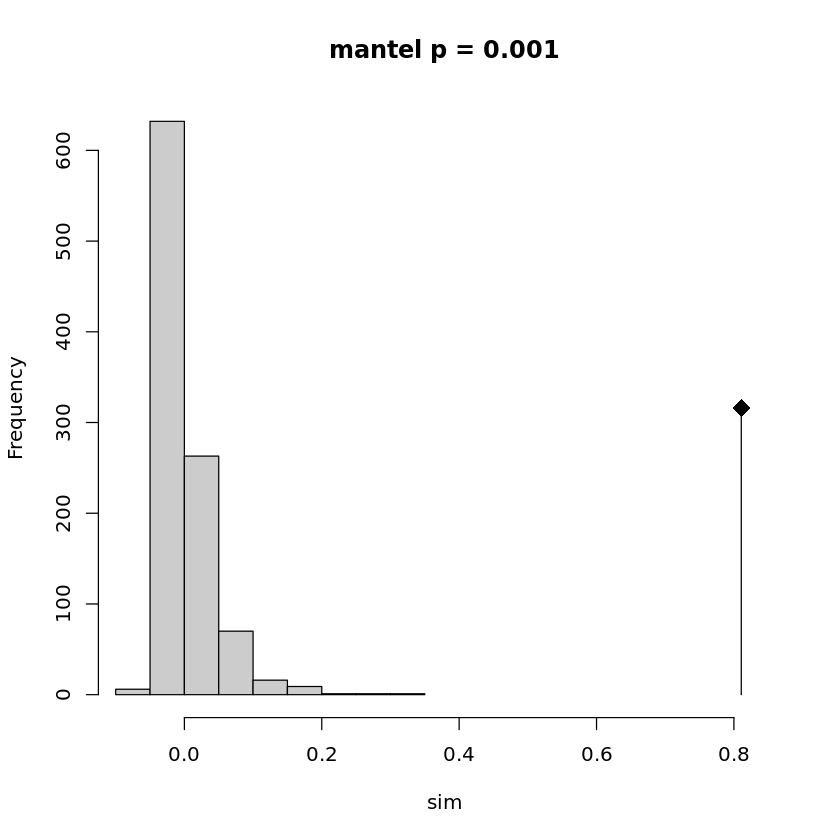

pdf 
  2

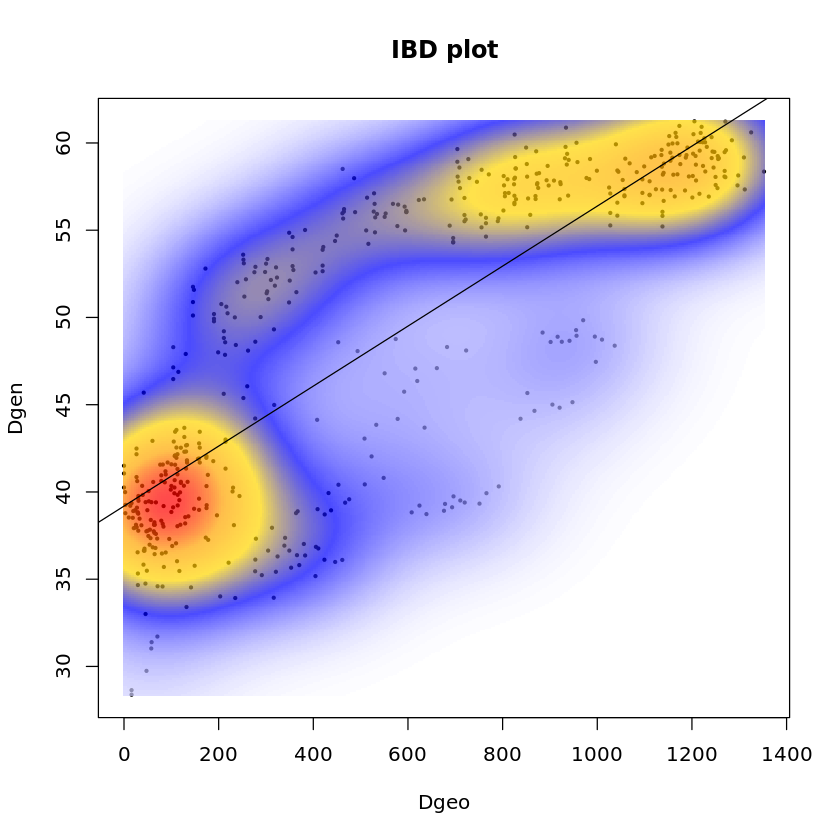

In [21]:
# plot out the IBD significance
plot(ibd, main=paste0("mantel p = ", ibd$pvalue))

## make kernel density plot of genetic and geographic distances
dens <- kde2d(as.numeric(Dgeo),as.numeric(Dgen), n=300)
myPal <- colorRampPalette(c("white","blue","gold", "orange", "red"))
plot(Dgeo, Dgen, pch=20,cex=.5)
image(dens, col=transp(myPal(300),.7), add=TRUE)
abline(lm(as.numeric(Dgen)~as.numeric(Dgeo)))
title("IBD plot")


## Below here, plot the same, but write it to a pdf

## PDF of mantel output and a kernel density plot of genetic vs. geographic distance
pdf(file="Mantel_KD.pdf", width=8, height=8)
plot(ibd, main=paste0("mantel p = ", ibd$pvalue)) # plot out the IBD significance

## make kernel density plot of genetic and geographic distances
plot(Dgeo, Dgen, pch=20,cex=.5)
image(dens, col=transp(myPal(300),.7), add=TRUE)
abline(lm(as.numeric(Dgen)~as.numeric(Dgeo)))
title("IBD plot")
dev.off()


Looking at the first plot:


<details>
  <summary>Click to show expected plot</summary>
  <img src="images/mantel.png" width=38% />
</details>



<br>


we can see that we have highly significant isolation by distance, with the lowest possible significance value given our number of permutations in the Mantel test (999 by default). The diamond-shaped point with the line indicates our empirical estimate, with the permutations shown as the gray histogram.

<br>

If we look at the second plot:


<details>
  <summary>Click to show expected plot</summary>
  <img src="images/kd_all.png" width=55% />
</details>

<br>


we can see how the geographic and genetic distances are correlated. What we see is a positive relationship, but with a major disjunction. This type of disjunction indicates the presence of some level of not fully continuous spatial genetic structure.

If we had only pure IBD, we would expect a single, roughly linear cloud of points. We won't reproduce this here, but when I looked at only the northern population, i found a pattern that looks much more like pure IBD.




<img src="images/kd_north.png" width=55% />




These plots can help reassure us that there is IBD in the data, but some kind of discrete structure across the whole species, which is what we are detecting with sNMF, etc., but no further discrete structure within the northern population.


<br>

## Grouped PCA

You might also want to combine multiple analyses into a single figure to show concodrance (or discrodance) among the analyses. We'll finishby exploring how to color the points of the PCA we ran earlier by the populations clusters identified by sNMF.

We'll use the `qmatrix` object that we extracted from the sNMF output (contains the proportions of ancestry from each cluster). We can iterate over the rows of this to find out which cluster each sample has the maximum membership in:

In [22]:
cluster <- apply(qmatrix, 1, which.max)

Then we can use this to create a vector of colors for each point when we plot the PCA:

In [23]:
PCA_cols <- cluster
PCA_cols[PCA_cols == 1] <- "red"
PCA_cols[PCA_cols == 2] <- "yellow"


Plot it out, setting these as the background (`bg`) colors for outlined circle points:

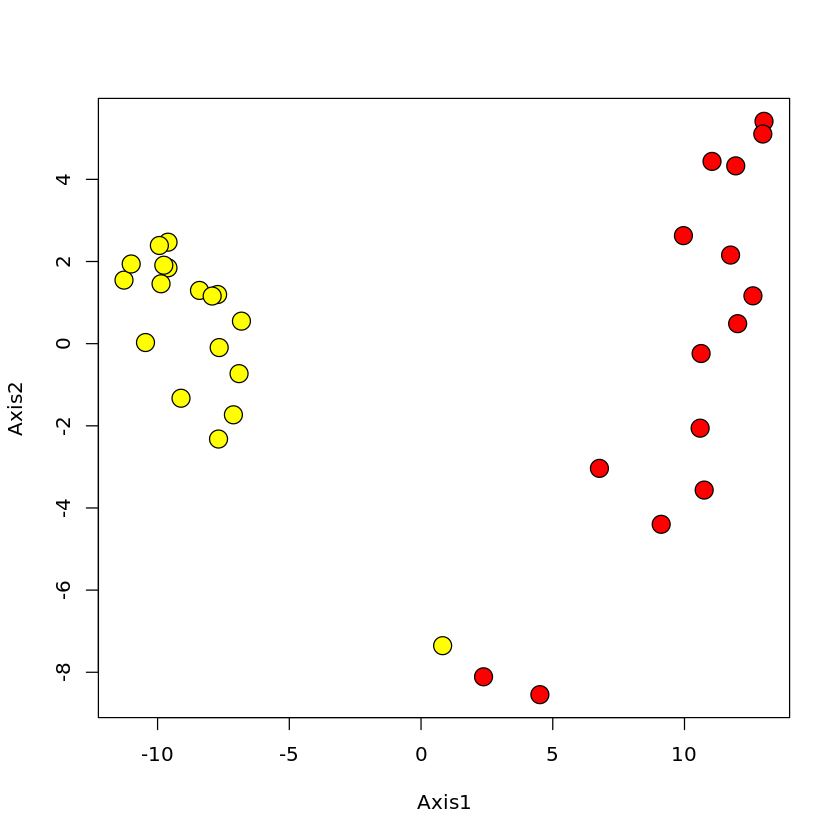

In [24]:
plot(pca_res$li, pch = 21, cex = 2, bg = PCA_cols)

You should see that this looks like it corresponds to our two populations.



<details>
  <summary>Click to show expected plot</summary>
  <img src="images/PCA2.png" width=38% />
</details>

<br>



What if we want to check if the three individuals in the middle are the ones identified as highly admixed by sNMF? We can use an apply statement with a simple anonymous function to find the rows of the Q matrix for individuals that do not have more than 0.7 of their ancestry from any single cluster:

In [25]:
high_admix <- apply(qmatrix, 1, function(x) max(x) < 0.7)

and then use this to index the `PCA_cols` object and swap out the colors of these individuals for orange, then re-plot:

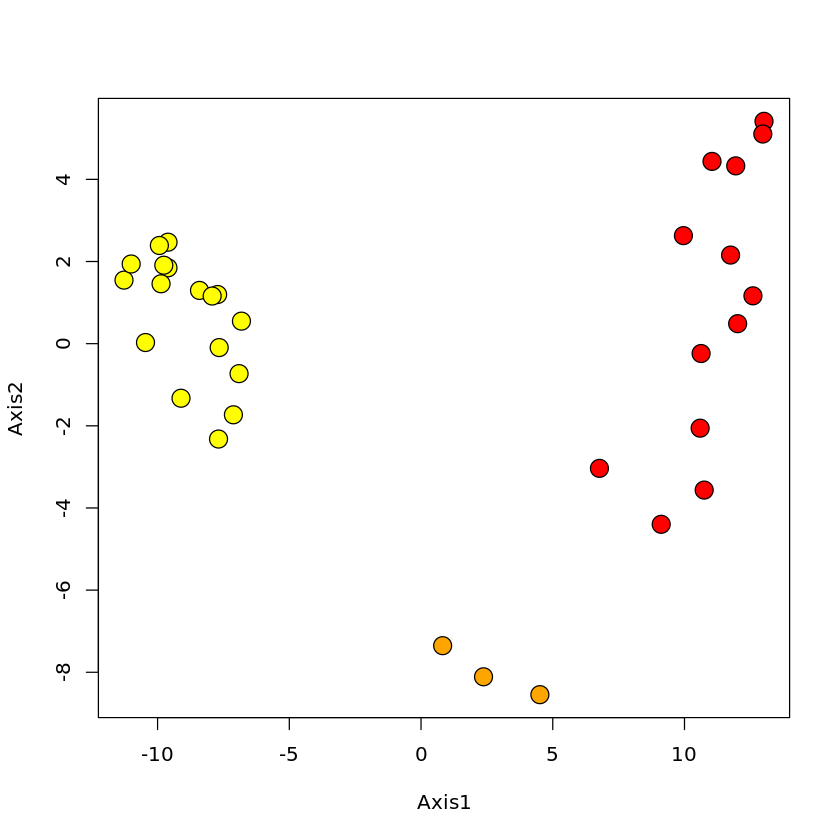

In [26]:
PCA_cols[high_admix] <- "orange"
plot(pca_res$li, pch = 21, cex = 2, bg = PCA_cols)

You should see that the admixed individuals are the admixed ones.


<details>
  <summary>Click to show expected plot</summary>
  <img src="images/PCA3.png" width=38% />
</details>


<br>



Since we only have two population clusters, we could also use ggplot and color points along a gradient depending on the value of ancestry in cluster 1. To do this, we'll make a single dataframe that has the PCA coordinates and the qmatrix values in it:

In [27]:
pca_q <- cbind(pca_res$li, qmatrix)

Then use ggplot to make a scatterplot colored along a gradient:

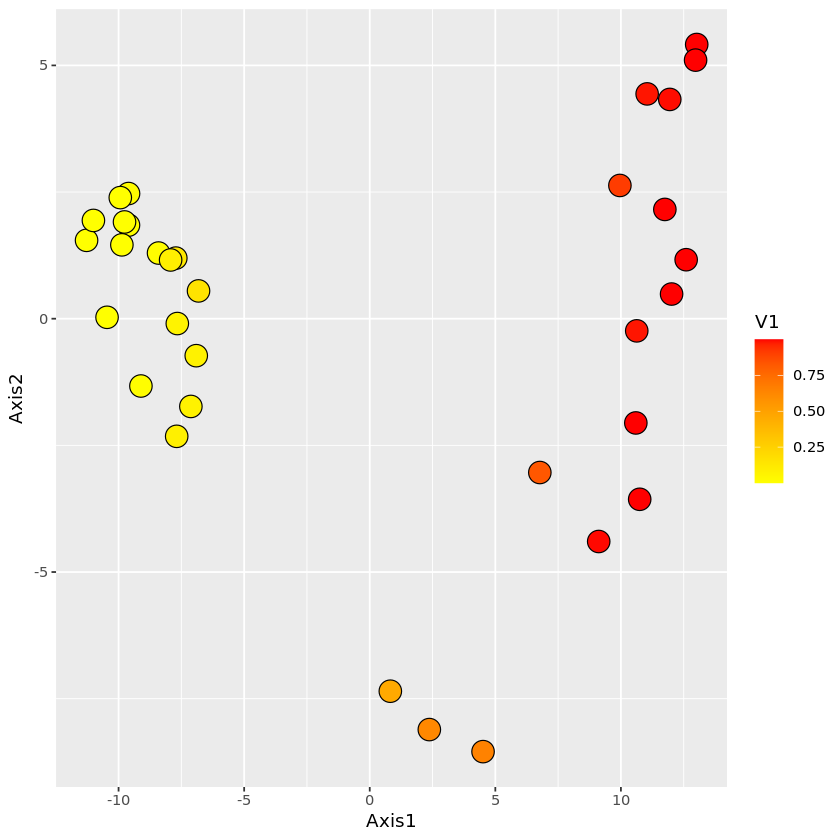

In [28]:
ggplot(pca_q, aes(x = Axis1, y = Axis2)) +
  geom_point(aes(fill = V1), size = 6, shape = 21, color = "black") +
  scale_fill_gradient(low = "yellow", high = "red")

This gives us a better idea of how much admixture there is in each sample.


<details>
  <summary>Click to show expected plot</summary>
  <img src="images/PCA4.png" width=38% />
</details>


<br>

We could do more tweaking to make this look better, but we'll stop here.

If we had more than just two populations, we wouldn't have a single gradient to color samples by. In that case, maybe you'd want to plot pies of admixture proportions on the PCA. Here is how you could do that, using similar code to when plotting pies on a map:

pdf 
  2

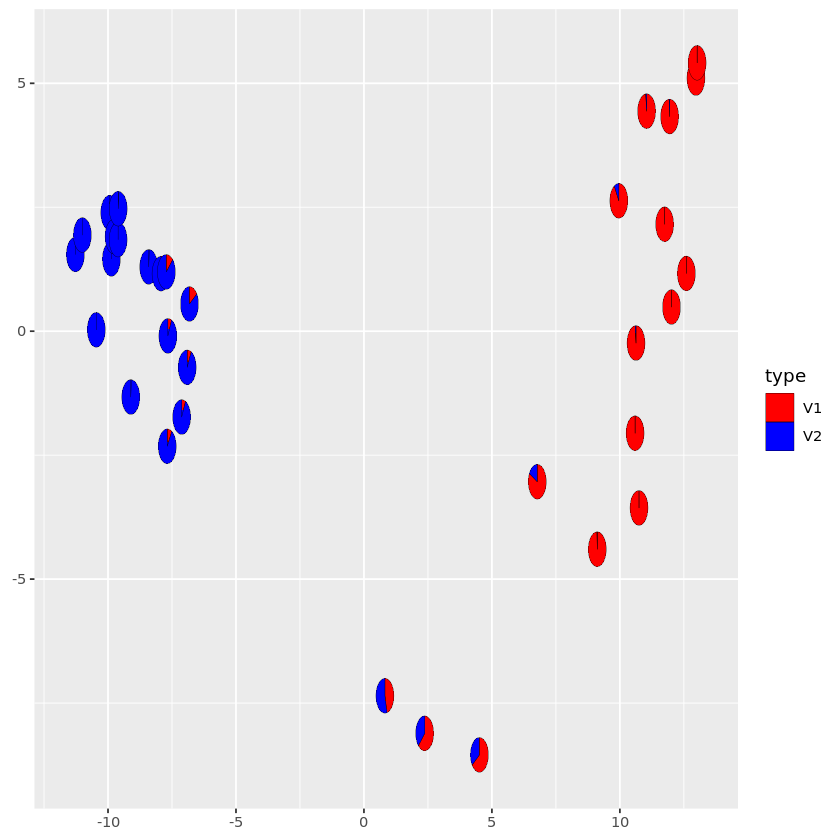

In [29]:
ggplot() +
  geom_scatterpie(data = pca_q, aes(x = Axis1, y = Axis2, r = 0.35), cols = grep("^V", colnames(pca_q), value = TRUE), size = 0.1) +
  scale_fill_manual(values = colors_2) # fill with the colors we defines above


# Same but plot to pdf
pdf(file="PCA_pies.pdf", width = 7, height = 5)
ggplot() +
  geom_scatterpie(data = pca_q, aes(x = Axis1, y = Axis2, r = 0.35), cols = grep("^V", colnames(pca_q), value = TRUE), size = 0.1) +
  scale_fill_manual(values = colors_2) # fill with the colors we defines above
dev.off()  



You should get wsomething that looks like this:

<details>
  <summary>Click to show expected plot</summary>
  <img src="images/PCA5.png" width=38% />
</details>


<br>


Again, we could alter the theme, legend, etc. to make this nicer, but we won't dig into that here.


## Test your knowledge


In [30]:
setwd("..")
html_content<-readr::read_file("quizzes/submodule_2/quiz1.html")
display_html(html_content)

Which methods are prone to being misled by continuous population structure?
 
 
 
 sNMF
 
 
 Structure
 
 
 conStruct
 
 
 GWAS
 
 
 Submit

In [31]:
html_content<-readr::read_file("quizzes/submodule_2/quiz2.html")
display_html(html_content)

Which methods are designed to detect discrete population structure (population clusters)?
 
 
 
 sNMF
 
 
 Structure
 
 
 Mantel tests
 
 
 GWAS
 
 
 Submit



# Conclusion

In this tutorial, we took the RADseq data that was assembled using ipyrad in the first submodule and performed population genetic analyses. We demonstrated how to calculate heterozygosity statistics, then ran methods to test for and visualize population structure. We introduced the clustering algorithm sNMF, prinicipal comonents analysis, and mantel tests for isolation by distance. Finally, we showed how to generate plots of population structure, including mapping these results.



<br>

# Cleanup

If you are not immediately moving on to the next notebook, shut down your GCP instance to prevent being charged while it sits idle.